In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# Add the parent directory (project root) to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

Added to path: D:\SPACE-BIOLOGY-KNOWLEDGE-ENGINE


In [3]:
from utils import show_prompt
from src.prompts import retrieval_agent_prompt
show_prompt(retrieval_agent_prompt, "Retrieval Agent Prompt")

╭──────────────────────────────────────────── Retrieval Agent Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a retrieval assistant, conducting retrieval from a vector database for answering user's input query.   │
│  For context, today's date is {date}.                                                                           │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to retrieve related information about the user's input query from the vector          │
│  database.                                                                                                      │
│  You can use any of the tools provided to you to find resources that can help answer the user's question. Your  │
│  retrieval is conducted in a tool-calling loop.                                                                 │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. search_research_papers: Use this tool to search the vector database with a query. This will return          │
│  relevant documents that can help answer the user's question.                                                   │
│  2. search_specific_topic: Use this tool to search the vector database with a specific topic. This is useful    │
│  for narrowing down your search to a particular area of interest.                                               │
│  3. think_tool                                                                                                  │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching): 

In [4]:
%%writefile ../src/state_retrieval.py

"""
State Definitions and Pydantic Schemas for Retrieval Agent

This module defines the state objects and structured schemas used for
the retrieval agent workflow, including retrieval state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ==== STATE DEFINITIONS ====

class RetrieverState(TypedDict):
    """
    State for the retrieval agent containing message history and retrieval metadata.

    This state tracks the retriever's conversation, iteration count for limiting
    tool calls, the retrieval topic being investigated
    and raw retrieval notes for detailed analysis.
    """

    retriever_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    retrieval_topic: str
    compressed_notes: str
    raw_notes: Annotated[List[str], operator.add]

class RetrieverOutputState(TypedDict):
    """
    Output state for the retriever agent containing final retrieval results.

    This represents the final output of the retrieval process with 
    all raw notes from the retrieval process.
    """
    raw_notes: Annotated[List[str], operator.add]
    compressed_notes: str
    retriever_messages: Annotated[Sequence[BaseMessage], add_messages]

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the retrieval scope",
    )
    verification: str = Field(
        description="Verify message that we will start retrieval after the user has provided the necessary information.",
    )

class RetrievalQuestion(BaseModel):
    """Schema for retrieval question generation."""
    retrieval_question: str = Field(
        description="A retrieval question that will be used to guide the retrieval.",
    )

class Summary(BaseModel):
    """Schema for retrieved content summarization."""
    summary: str = Field(description="Concise summary of the retrieved content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the retrieved content")

Overwriting ../src/state_retrieval.py


In [5]:
%%writefile ../src/utils.py

"""
Retrieval Utilities and Tools. 

This module provides utility functions and tools to support the retrieval process.
"""

from pathlib import Path
from datetime import datetime
import platform
from typing_extensions import Annotated, List

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_community.vectorstores import Qdrant
from langchain_huggingface import HuggingFaceEmbeddings
from qdrant_client import QdrantClient

from src.config import QDRANT_PATH, COLLECTION_NAME, EMBEDDING_MODEL
from src.state_retrieval import Summary
from src.prompts import summarize_retrieved_content_prompt

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    # Windows-compatible date format
    if platform.system() == "Windows":
        date_str = datetime.now().strftime("%a %b %d, %Y")
        parts = date_str.split()
        if len(parts) >= 3 and parts[2].startswith('0'):
            parts[2] = parts[2][1:]
        return ' '.join(parts)
    else:
        return datetime.now().strftime("%a %b %-d, %Y")

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

def get_vector_store():
    """Initialize and return the Qdrant vector store."""
    embeddings = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL,
        model_kwargs={'device': 'cpu'},
        encode_kwargs={'normalize_embeddings': True}
    )

    client = QdrantClient(url="http://localhost:6333")

    vector_store = Qdrant(
        client=client,
        collection_name=COLLECTION_NAME,
        embeddings=embeddings
    )
    
    return vector_store

def format_source_metadata(doc, index: int) -> str:
    """Format source information using rich metadata."""
    metadata = doc.metadata
    
    # Extract clean information from your rich metadata
    pmc_id = metadata.get('pmc_id', 'Unknown PMC')
    title = metadata.get('title', metadata.get('filename', 'Unknown title'))
    organisms = metadata.get('organisms', [])
    research_types = metadata.get('research_types', [])
    
    # Clean up title (remove file extension artifacts)
    if title.endswith('.pdf'):
        title = title[:-4]
    
    # Format organisms and research types
    org_str = f" | Organisms: {', '.join(organisms[:2])}" if organisms and organisms != ['unknown'] else ""
    type_str = f" | Type: {', '.join(research_types[:2])}" if research_types and research_types != ['general'] else ""
    
    return f"[{index}] {pmc_id}: {title[:60]}...{org_str}{type_str}"

# Initialize summarization model
summarization_model = init_chat_model(model="openai:gpt-4o-mini")

def summarize_retrieved_content(retrieved_content: str) -> str:
    """Summarize retrieved research content using structured output.
    
    Args:
        retrieved_content: Raw retrieved content from vector search
        
    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_retrieved_content_prompt.format(
                date=get_today_str(),
                retrieved_content=retrieved_content
            ))
        ])
        
        # Format summary with clear structure
        formatted_summary = (
            f"**Summary:**\n{summary.summary}\n\n"
            f"**Key Excerpts:**\n{summary.key_excerpts}"
        )
        
        return formatted_summary
        
    except Exception as e:
        print(f"Failed to summarize content: {str(e)}")
        # Fallback: return first 2000 chars if summarization fails
        return retrieved_content[:2000] + "..." if len(retrieved_content) > 2000 else retrieved_content

# ===== RETRIEVAL TOOLS =====

@tool
def search_research_papers(query: str, max_results: int = 5) -> str:
    """
    Search through space biology research papers for relevant information.
    
    Args:
        query: The search query describing what information you're looking for
        max_results: Maximum number of results to return (default: 5, max: 15)
    
    Returns:
        String containing research findings (automatically summarized if content is too long)
    """
    
    max_results = min(max_results, 15)
    
    try:
        vector_store = get_vector_store()
        docs = vector_store.similarity_search(query, k=max_results)
        
        if not docs:
            return f"No relevant research papers found for query: '{query}'"
        
        # Combine all content
        all_content = []
        sources = []
        
        for i, doc in enumerate(docs, 1):
            # Use rich metadata for source formatting
            source_info = format_source_metadata(doc, i)
            sources.append(source_info)
            all_content.append(f"Research Finding {i}:\n{doc.page_content}")
        
        combined_content = "\n\n".join(all_content)
        source_list = "\n".join(sources)
        
        # Auto-summarize if content is too long (> 3000 characters)
        if len(combined_content) > 3000:
            summary = summarize_retrieved_content(combined_content)
            return f"{summary}\n\n**Sources:**\n{source_list}"
        else:
            return f"{combined_content}\n\n**Sources:**\n{source_list}"
    
    except Exception as e:
        return f"Error searching research papers: {str(e)}"


@tool
def search_specific_topic(topic: str, keywords: List[str], max_results: int = 8) -> str:
    """
    Search for specific topics using targeted keywords for more focused results.
    
    Args:
        topic: The main topic you're researching
        keywords: List of specific keywords to focus the search
        max_results: Maximum number of results (default: 8, max: 12)
    
    Returns:
        String containing focused research findings (automatically summarized if content is too long)
    """
    
    max_results = min(max_results, 12)
    
    # Simple query construction
    keyword_str = " ".join(keywords)
    focused_query = f"{topic} {keyword_str}"
    
    try:
        vector_store = get_vector_store()
        docs = vector_store.similarity_search(focused_query, k=max_results)
        
        if not docs:
            return f"No specific research found for topic '{topic}' with keywords: {keywords}"
        
        # Combine all content
        all_content = []
        sources = []
        
        for i, doc in enumerate(docs, 1):
            # Use rich metadata for source formatting
            source_info = format_source_metadata(doc, i)
            sources.append(source_info)
            all_content.append(f"{topic} Finding {i}:\n{doc.page_content}")
        
        combined_content = "\n\n".join(all_content)
        source_list = "\n".join(sources)
        
        # Auto-summarize if content is too long (> 3000 characters)
        if len(combined_content) > 3000:
            summary = summarize_retrieved_content(combined_content)
            return f"{summary}\n\n**Sources:**\n{source_list}"
        else:
            return f"{combined_content}\n\n**Sources:**\n{source_list}"
        
    except Exception as e:
        return f"Error in focused search: {str(e)}"


@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the retrieval workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/utils.py


In [6]:
%%writefile ../src/retrieval_agent.py

"""Retrieval Agent Implementation.

This module implements a retrieval agent that can perform iterative
searches and synthesis to answer complex retrieval questions related to Space biology research.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from src.state_retrieval import RetrieverState, RetrieverOutputState
from src.prompts import retrieval_agent_prompt, compress_research_human_message, compress_research_system_prompt
from src.utils import search_research_papers, search_specific_topic, think_tool, get_today_str

# ==== CONFIGURATION ====

# Set up tools and model binding
tools = [search_research_papers, search_specific_topic, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# initialize models 
model = init_chat_model(model="openai:gpt-4o-mini")
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model="openai:gpt-4.1-nano")
compress_model = init_chat_model(model="openai:gpt-4o-mini")

# ==== AGENT NODES ====

def llm_call(state: RetrieverState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "retriever_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=retrieval_agent_prompt)] + state["retriever_messages"],
            )
        ]
    }

def tool_node(state: RetrieverState):
    """
    Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["retriever_messages"][-1].tool_calls

    # Execute all tool calls 
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))

    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]

    return {"retriever_messages": tool_outputs}

def compress_retrieval(state: RetrieverState):
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """

    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("retriever_messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)

    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["retriever_messages"],
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_notes": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ==== ROUTING LOGIC ====

def should_continue(state: RetrieverState) -> Literal["tool_node", "compress_retrieval"]:
    """Determine whether to continue retrieval process or provide final answer.
    
    Determines whether the agent should continue the retrieval loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress retrieval findings
    """
    
    messages = state["retriever_messages"]
    last_message = messages[-1]

    # If the LLM makes a tool_call, continue to tool execution 
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we have the final answer
    return "compress_retrieval"

# ==== GRAPH CONSTRUCTION ====

# Build the agent workflow 
agent_builder = StateGraph(RetrieverState, output_schema=RetrieverOutputState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_retrieval", compress_retrieval)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call", 
    should_continue, 
    {
        "tool_node": "tool_node", # Continue retrieval
        "compress_retrieval": "compress_retrieval" # Provide final answer
    }
)
agent_builder.add_edge("tool_node", "llm_call")
agent_builder.add_edge("compress_retrieval", END)

# Compile the graph
retrieval_agent = agent_builder.compile()


Overwriting ../src/retrieval_agent.py


d:\SPACE-BIOLOGY-KNOWLEDGE-ENGINE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


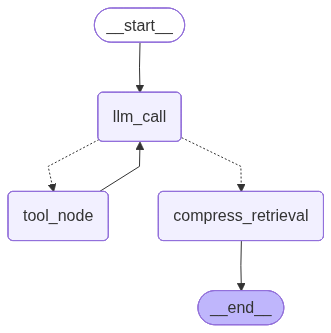

In [7]:
from IPython.display import Image, display
from src.retrieval_agent import retrieval_agent

# Show the agent
display(Image(retrieval_agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
# Run the agent 
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
retrieval_brief = "How does microgravity affect human muscle atrophy during long-duration space missions?"

result = retrieval_agent.invoke({"retriever_messages": [HumanMessage(content=retrieval_brief)]})
format_messages(result["retriever_messages"])

D:\SPACE-BIOLOGY-KNOWLEDGE-ENGINE\src\utils.py:62: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  vector_store = Qdrant(


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ How does microgravity affect human muscle atrophy during long-duration space missions?                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: search_research_papers                                                                            │
│    Args: {                                                                                                      │
│   "query": "microgravity human muscle atrophy long-duration space missions",                                    │
│   "max_results": 5                                                                                              │
│ }                                                                                                               │
│    ID: call_t0If7ot5Sib1V6YPRYsvXgrr                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **Summary:**                                                                                                    │
│ Research indicates that muscle atrophy is a significant concern for astronauts during long-duration             │
│ spaceflights, particularly in microgravity environments. They experience up to a 20% loss of muscle mass and    │
│ 30% loss of muscle strength during missions lasting up to six months, particularly affecting postural muscles   │
│ crucial for mobility. Daily exercise routines, involving both aerobic and resistance training for up to 2.5     │
│ hours, are currently employed as countermeasures to mitigate these losses; however, they are not entirely       │
│ effective. Recent studies show that even short durations of microgravity—several days—can lead to muscle fiber  │
│ atrophy and decreased endurance. Notably, muscle loss correlates with increased physical health risks           │
│ post-mission, including chronic pain and susceptibility to injury. Research continues into optimizing exercise  │
│ and nutrition to preserve muscle integrity during space travel. Key factors contributing to muscle loss include │
│ reduced workload and altered metabolism. Published data highlights a monthly muscle mass decline of             │
│ approximately 3% in astronauts on the International Space Station (ISS). Understanding these effects is vital   │
│ for planning future long-term missions, such as potential journeys to Mars.                                     │
│                                                                                                                 │
│ **Key Excerpts:**                                                                                               │
│ 1. "A month in space can result in a 20% reduction in muscle mass and 30% in muscle strength."                  │
│ 2. "Even with exercise countermeasures, the physiological effects of spaceflight on muscle atrophy are not      │
│ completely abrogated."                                                                                          │
│ 3. "Astronauts experience a 3% loss in muscle mass for every month in microgravity."                            │
│ 4. "Loss of lean mass post-mission is associated with chronic low-back pain and increased injury risk."         │
│                                                                                                                 │
│ **Sources:**                                                                                                    │
│ [1] PMC9640571: Microfluidics-integrated spaceflight hardware for ... | Organisms: Caenorhabditis, elegans      │
│ [2] PMC4653813: Spaceflight and hind limb unloading induce similar... | Organisms: mouse, rat                   │
│ [3] PMC10504369: Impacts of radiation exposure, hindlimb unloading,... | Organisms: human, rat                  │
│ [4] PMC9640571: Microfluidics-integrated spaceflight hardware for ... | Organisms: Caenorhabditis, elegans      │
│ [5] PMC8493566: Hindlimb suspension in Wistar rats_ Sex-based diff... | Organisms: rat                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I found significant information regarding how microgravity affects human muscle atrophy during │
│ long-duration missions. Key points include the fact that astronauts can experience up to a 20% reduction in     │
│ muscle mass and a 30% decline in muscle strength over six months, with countermeasures like exercise being      │
│ employed to mitigate these effects. However, even with these countermeasures, complete prevention of atrophy is │
│ not achieved. The information is quite relevant, but I need to look for more specific studies or findings on    │
│ countermeasures and physiological mechanisms involved."                                                         │
│ }                                                                                                               │
│    ID: call_0m4mxA6AHzAE7zvX30tvYRef                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I found significant information regarding how microgravity affects human muscle atrophy    │
│ during long-duration missions. Key points include the fact that astronauts can experience up to a 20% reduction │
│ in muscle mass and a 30% decline in muscle strength over six months, with countermeasures like exercise being   │
│ employed to mitigate these effects. However, even with these countermeasures, complete prevention of atrophy is │
│ not achieved. The information is quite relevant, but I need to look for more specific studies or findings on    │
│ countermeasures and physiological mechanisms involved.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: search_specific_topic                                                                             │
│    Args: {                                                                                                      │
│   "topic": "microgravity",                                                                                      │
│   "keywords": [                                                                                                 │
│     "muscle atrophy",                                                                                           │
│     "countermeasures",                                                                                          │
│     "physiological mechanisms"                                                                                  │
│   ],                                                                                                            │
│   "max_results": 8                                                                                              │
│ }                                                                                                               │
│    ID: call_f1DbP7c23C1ZHkMcWE0vmvIZ                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **Summary:**                                                                                                    │
│ This collection of findings highlights the significant impact of microgravity on skeletal muscle atrophy, which │
│ occurs due to reduced load and altered metabolism during spaceflight. Critical antigravity muscles, such as the │
│ soleus and gastrocnemius, are particularly affected, losing up to 30% of mass and strength during long          │
│ missions. Despite current exercise countermeasures, some muscle loss remains unavoidable, underscoring the need │
│ to explore fundamental mechanisms, like gene expression changes in muscle proteins, that contribute to atrophy. │
│ Advanced methodologies, including machine learning algorithms, have been utilized to identify key genes         │
│ involved in muscular atrophy and propose novel drug candidates for treatment. Notably, alterations in Ca2+      │
│ regulation associated with muscle relaxation have been linked to this phenomenon. Understanding these changes   │
│ is essential for ensuring the health of astronauts on long-duration missions and for addressing similar         │
│ conditions on Earth.                                                                                            │
│                                                                                                                 │
│ **Key Excerpts:**                                                                                               │
│ - "A major detriment experienced by astronauts in flight is muscle atrophy, where a 1 month spaceflight can     │
│ reduce muscle mass by 20% and muscle strength by 30%."                                                          │
│ - "Current countermeasures... are not completely abrogated. In addition to microgravity, astronaut exposure to  │
│ cosmic radiation can have effects on body systems that are still being elucidated."                             │
│ - "We have mined seven GeneLab datasets to identify key genes and drugs... to manage skeletal muscle atrophy in │
│ spaceflight microgravity."                                                                                      │
│ - "Muscle atrophy may be at least partly explained by the dysregulation of cytoplasmic Ca2+ levels due to       │
│ abnormalities in the Sarco Endoplasmic Reticulum Calcium ATPase (SERCA) pump."                                  │
│ - "Understanding these metabolic changes induced in spaceflight contributes to understanding the cause of       │
│ muscle decline and alterations in other tissue systems observed in astronauts."                                 │
│                                                                                                                 │
│ **Sources:**                                                                                                    │
│ [1] PMC8430797: Mammalian and Invertebrate Models as Complementary... | Organisms: rat                          │
│ [2] PMC9640571: Microfluidics-integrated spaceflight hardware for ... | Organisms: Caenorhabditis, elegans      │
│ [3] PMC10504369: Impacts of radiation exposure, hindlimb unloading,... | Organisms: human, rat                  │
│ [4] PMC8953707: Detection of Target Genes for Drug Repurposing to ... | Organisms: rat | Type: genomic          │
│ [5] PMC9640571: Microfluidics-integrated spaceflight hardware for ... | Organisms: Caenorhabditis, elegans      │
│ [6] PMC10344948: Caenorhabditis elegans in microgravity_ An omics p... | Organisms: Caenorhabditis, elegans     │
│ [7] PMC8953707: Detection of Target Genes for Drug Repurposing to ... | Organisms: rat | Type: genomic          │
│ [8] PMC10719374: Explainable machine learning identifies multi-omic... | Organisms: mouse, rat                  │
╰────────────────────────────────────────────────────────

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The second search provided more in-depth findings on muscle atrophy mechanisms in              │
│ microgravity. Key details include specific muscles most affected, gene expression changes, and potential drug   │
│ candidates for mitigating atrophy. However, while I have solid information on the physiological impacts and     │
│ some countermeasures, I still lack detailed examples of specific countermeasure programs in current missions    │
│ and how effective they are. A focused inquiry into operational countermeasures could provide the final insights │
│ needed."                                                                                                        │
│ }                                                                                                               │
│    ID: call_9qVylWwwZzUilQeUA8wSvBb8                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The second search provided more in-depth findings on muscle atrophy mechanisms in          │
│ microgravity. Key details include specific muscles most affected, gene expression changes, and potential drug   │
│ candidates for mitigating atrophy. However, while I have solid information on the physiological impacts and     │
│ some countermeasures, I still lack detailed examples of specific countermeasure programs in current missions    │
│ and how effective they are. A focused inquiry into operational countermeasures could provide the final insights │
│ needed.                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: search_specific_topic                                                                             │
│    Args: {                                                                                                      │
│   "topic": "space missions",                                                                                    │
│   "keywords": [                                                                                                 │
│     "exercise countermeasures",                                                                                 │
│     "keeping muscle",                                                                                           │
│     "NASA programs"                                                                                             │
│   ],                                                                                                            │
│   "max_results": 8                                                                                              │
│ }                                                                                                               │
│    ID: call_I10UUx6MGrn8MXn4LLQJ2LRe                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **Summary:**                                                                                                    │
│ Recent studies on countermeasures for muscle atrophy and skeletal alterations during space missions have        │
│ highlighted the challenges faced by astronauts due to prolonged exposure to microgravity. Notably, muscle       │
│ atrophy is a significant concern, as traditional exercise interventions aboard the International Space Station  │
│ (ISS) require approximately 2.5 hours daily but still do not fully prevent muscle loss. Through various         │
│ research methodologies, including animal studies compliant with ARRIVE guidelines and approved by relevant      │
│ IACUCs, key findings have emerged regarding genetic changes linked to microgravity that resemble responses      │
│ observed in vertebrate and invertebrate models. Potential biomarkers, such as Acyp1 and Rps7 proteins, may      │
│ serve as targets for future interventions. Additionally, pharmacological approaches like bisphosphonates and    │
│ myostatin inhibitors show promise as countermeasures against skeletal muscle atrophy. Research continues to     │
│ explore effective strategies, including the impact of nutritional and therapeutic interventions, highlighting   │
│ the urgent need for comprehensive solutions to mitigate health risks for astronauts in long-duration            │
│ spaceflights. This research context is essential for guiding future human exploration missions to the Moon and  │
│ Mars. Relevant studies include findings published in the American Journal of Physiology (2022) and Npj          │
│ Microgravity (2023).                                                                                            │
│                                                                                                                 │
│ **Key Excerpts:**                                                                                               │
│ - "Muscle atrophy, caused by prolonged exposure to microgravity conditions, is a major challenge faced by       │
│ astronauts during spaceflight."                                                                                 │
│ - "Although intense physical exercise is currently the main countermeasure, it requires a significant amount of │
│ time from each astronaut (2.5 hours per day)...even with exercise, the continuous exposure to microgravity      │
│ cannot be fully offset."                                                                                        │
│ - "To mitigate musculoskeletal losses, NASA has instigated strict requirements for exercise interventions on    │
│ the ISS."                                                                                                       │
│                                                                                                                 │
│ **Sources:**                                                                                                    │
│ [1] PMC8131644: Spaceflight and hind limb unloading induces an art...                                           │
│ [2] PMC9640571: Microfluidics-integrated spaceflight hardware for ... | Organisms: Caenorhabditis, elegans      │
│ [3] PMC10605753: Spaceflight Induces Strength Decline in Caenorhabd... | Organisms: Caenorhabditis, elegans     │
│ [4] PMC10831389: Sex differences in muscle health in simulated micr... | Organisms: rat                         │
│ [5] PMC10831389: Influence of gonadectomy on muscle health in micro... | Organisms: rat                         │
│ [6] PMC10719374: Explainable machine learning identifies multi-omic... | Organisms: mouse, rat                  │
│ [7] PMC8953707: Detection of Target Genes for Drug Repurposing to ... | Organisms: rat | Type: genomic          │
│ [8] PMC7870178: Comprehensive multi-omics analysis reve

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The final search provided several insights into current countermeasures being used against     │
│ muscle atrophy in space missions. It's clear that despite rigorous exercise regimes aboard the ISS requiring    │
│ around 2.5 hours daily, complete prevention of muscle loss is still not achieved. There are also emerging       │
│ pharmacological approaches and biomarkers that may help address this issue. However, while I now have a         │
│ comprehensive understanding of countermeasures, I am still missing specific examples of NASA\u2019s operational │
│ protocols or case studies showcasing the effectiveness of these strategies during missions. This could finalize │
│ my response."                                                                                                   │
│ }                                                                                                               │
│    ID: call_3oJyxU7VqXNsgYsb7CyEx1F0                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The final search provided several insights into current countermeasures being used against │
│ muscle atrophy in space missions. It's clear that despite rigorous exercise regimes aboard the ISS requiring    │
│ around 2.5 hours daily, complete prevention of muscle loss is still not achieved. There are also emerging       │
│ pharmacological approaches and biomarkers that may help address this issue. However, while I now have a         │
│ comprehensive understanding of countermeasures, I am still missing specific examples of NASA’s operational      │
│ protocols or case studies showcasing the effectiveness of these strategies during missions. This could finalize │
│ my response.                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I've gathered substantial information on how microgravity affects human muscle atrophy during long-duration     │
│ space missions. Here are the key findings:                                                                      │
│                                                                                                                 │
│ 1. **Muscle Atrophy Rates**: Astronauts in microgravity experience significant muscle atrophy, with studies     │
│ indicating a loss of about 20% in muscle mass and 30% in muscle strength after missions lasting six months.     │
│ Specific postural muscles, like the soleus and gastrocnemius, are particularly affected.                        │
│                                                                                                                 │
│ 2. **Countermeasures**: Current countermeasures primarily involve daily exercise routines that require about    │
│ 2.5 hours. These interventions, focusing on both aerobic fitness and resistance training, help mitigate but do  │
│ not completely prevent muscle loss. Despite these efforts, astronauts still exhibit a decline in muscle mass at │
│ a rate of approximately 3% per month.                                                                           │
│                                                                                                                 │
│ 3. **Physiological Mechanisms**: The underlying mechanisms for muscle atrophy in space include reduced          │
│ gravitational load and altered metabolism. There are significant changes in muscle-related gene expression and  │
│ calcium regulation that contribute to these effects, which highlight the complexity of muscle maintenance in    │
│ microgravity environments.                                                                                      │
│                                                                                                                 │
│ 4. **Emerging Solutions**: Research has pointed to potential pharmacological interventions, including myostatin │
│ inhibitors and bisphosphonates, that may complement physical exercise in counteracting muscle atrophy.          │
│ Additionally, the identification of biomarkers linked to muscle health poses potential for developing targeted  │
│ therapies in the future.                                                                                        │
│                                                                                                                 │
│ 5. **Implications for Future Missions**: Understanding muscle atrophy and the effectiveness of current          │
│ countermeasures is essential for planning long-duration missions, such as those to Mars or deep space           │
│ exploration. Ongoing research aims to optimize exercise and nutritional strategies, as well as to evaluate new  │
│ pharmacological options, ensuring astronaut health during extended periods in microgravity.                     │
│                                                                                                                 │
│ While there is a wealth of information on the physiological impacts and general countermeasures used, I still   │
│ lack specific examples of NASA’s operational protocols or a systematic overview of the effectiveness of these   │
│ strategies currently employed in missions. Therefore, I recommend that future searches focus on detailed case   │
│ studies or specific NASA documentation related to muscle atrophy countermeasures in space missions for a more   │
│ comprehensive understanding.                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
from rich.markdown import Markdown
Markdown(result['compressed_notes'])

List of Queries and Tool Calls Made                                                                                

 1 Search for "microgravity human muscle atrophy long-duration space missions."                                    
 2 Search for "microgravity" with keywords "muscle atrophy," "countermeasures," "physiological mechanisms."        
 3 Search for "space missions" with keywords "exercise countermeasures," "keeping muscle," "NASA programs."        

Fully Comprehensive Findings                                                                                       

  1 Research indicates that muscle atrophy is a significant concern for astronauts during long-duration            
    spaceflights, particularly in microgravity environments. They experience up to a 20% loss of muscle mass and   
    30% loss of muscle strength during missions lasting up to six months, particularly affecting postural muscles  
    crucial for mobility.                                                                                          
  2 Daily exercise routines, involving both aerobic and resistance training for up to 2.5 hours, are currently     
    employed as countermeasures to mitigate these losses; however, they are not entirely effective.                
  3 Recent studies show that even short durations of microgravity—several days—can lead to muscle fiber atrophy and
    decreased endurance.                                                                                           
  4 Notably, muscle loss correlates with increased physical health risks post-mission, including chronic pain and  
    susceptibility to injury.                                                                                      
  5 Research continues into optimizing exercise and nutrition to preserve muscle integrity during space travel.    
  6 Key factors contributing to muscle loss include reduced workload and altered metabolism.                       
  7 Published data highlights a monthly muscle mass decline of approximately 3% in astronauts on the International 
    Space Station (ISS).                                                                                           
  8 Understanding these effects is vital for planning future long-term missions, such as potential journeys to     
    Mars.                                                                                                          
  9 Muscle atrophy, caused by prolonged exposure to microgravity conditions, is a major challenge faced by         
    astronauts during spaceflight.                                                                                 
 10 Although intense physical exercise is currently the main countermeasure, it requires a significant amount of   
    time from each astronaut (2.5 hours per day)...even with exercise, the continuous exposure to microgravity     
    cannot be fully offset.                                                                                        
 11 To mitigate musculoskeletal losses, NASA has instigated strict requirements for exercise interventions on the  
    ISS.                                                                                                           
 12 A major detriment experienced by astronauts in flight is muscle atrophy, where a 1 month spaceflight can reduce
    muscle mass by 20% and muscle strength by 30%.                                                                 
 13 Current countermeasures... are not completely abrogated. In addition to microgravity, astronaut exposure to    
    cosmic radiation can have effects on body systems that are still being elucidated.                             
 14 Muscle atrophy may be at least partly explained by the dysregulation of cytoplasmic Ca2+ levels due to         
    abnormalities in the Sarco Endoplasmic Reticulum Calcium ATPase (SERCA) pump.                                  
 15 Understanding these metabolic changes induced in 